# Quant 101
## #2 Régression Linéaire : $\alpha$, $\beta$ et le CAPM

## Rappel de l'atelier précédent
- Rendements : simples vs logarithmiques. Comment le prix d'un actif évolue-t-il dans le temps ?
- Volatilité : mesure du risque. Comment quantifier les fluctuations d'un actif ?
- Corrélations : interdépendance entre actifs. Comment les actifs évoluent-ils ensemble ?

### Lien avec la régression linéaire
- En finance, on utilise souvent la régression linéaire pour estimer le **$\alpha$** (rendement excédentaire) et le **$\beta$** (sensibilité au marché) d'un actif.
- On passe d'une relation descriptive (corrélation) à une relation quantifiée (régression).
    - Après avoir appris à mesurer, on apprend à expliquer et prédire.

## Objectifs du jour
- Comprendre et pouvoir estimer les valeurs d'**$\alpha$** et de **$\beta$**
- Introduire le concept du **CAPM** (Capital Asset Pricing Model) de manière pratique
- Construire un mini-modèle de pricing sur des données réelles

## Intuition derrière le modèle de régression linéaire

![Scatter](figures/scatter_plot.png)

### Pente 
**$\beta$** : mesure la sensibilité de l'actif aux mouvements du marché.
- **$\beta = 1$** : l'actif suit parfaitement le marché.
- **$\beta > 1$** : l'actif amplifie les mouvements du marché.
- **$\beta < 1$** : l'actif amortit les mouvements du marché.
- **$\beta < 0$** : l'actif évolue en sens inverse du marché.

- Tendance moyenne extraite via la régression linéaire.

### Ordonnée à l'origine 
**$\alpha$** : rendement excédentaire qui s'ajoute à celui prédit par le marché.
- **$\alpha > 0$** : l'actif surperforme par rapport à ce que le marché suggère.
- **$\alpha < 0$** : l'actif sous-performe par rapport à ce que le marché suggère.

- La partie de la performance non expliquée par le marché.

### La dispersion (variance des résidus) 
Le risque spécifique à l'actif, non capturé par le marché.
- Plus la dispersion est grande, plus l'actif est risqué indépendamment des mouvements du marché.
- Lié au concept de risque *spécifique* (idiosyncratique)

### Risque systématique vs spécifique
#### Risque systématique
Le risque provenant du *marché lui-même* : cycles économiques, sentiment global, événements macroéconomiques.
- Affecte tous les actifs.
- Ne peut pas être éliminé par la diversification.
- Capturé par le **$\beta$**.

#### Risque spécifique (idiosyncratique)
Le risque propre à un actif individuel : management, structure financière, événements propres à l'entreprise.
- Peut être réduit par la diversification.
- Capturé par la dispersion des résidus dans la régression.
- Le $R^2$ mesure la proportion de la variance expliquée par le modèle. (haute proportion = faible risque spécifique)

![Scatter](figures/linreg_plot.png)

## Statistiques de base

On tente de fit une droite aux points (rendements de l'actif vs rendements du marché) en minimisant la somme des carrés des distances verticales (résidus).  
On a un modèle de la forme : 
$$
r_i = \alpha + \beta r_m + \epsilon
$$

### Définitions
- $\beta$ = Cov($r_i$, $r_m$) / Var($r_m$)
- $\alpha$ = intercept $\rightarrow$ non-expliqué par le marché
- $\epsilon$ = bruit $\rightarrow$ diversifiable

### p-values
- Mesure la signification statistique des coefficients estimés.
- p-value faible (généralement < 0.05) indique que le coefficient est statistiquement significatif.
- Permet de tester l'hypothèse nulle selon laquelle le coefficient n'a pas d'effet

### Variances
- Var($r_i$) = $\beta^2$ Var($r_m$) + Var($\epsilon$)
- R² = proportion de la variance (du risque) expliquée par le modèle
- La variance totale de l'actif est décomposée en une partie expliquée par le marché et une partie spécifique (résidus).

## Code Python

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels pour la régression et tou ce qui est statistiques
import statsmodels.api as sm

plt.style.use('seaborn-v0_8-darkgrid')

## Téléchargement des données et visualisation rapide

In [ ]:
tickers = ["AAPL", "JPM"] # Ex : Apple et JPMorgan Chase 
market_ticker = "^GSPC" # Ex : S&P 500

prices = yf.download(tickers + [market_ticker], period="10y")["Close"]

returns = prices.pct_change().dropna()

cum_returns = (1 + returns).cumprod()

# On peut tracer les rendements cumulatifs
cum_returns.plot(figsize=(12,6), title="Rendements cumulatifs")

## Approche rapide avec le modèle OLS de `statsmodels` pour estimer $\alpha$ et $\beta$


In [ ]:
asset = "AAPL" # Choisissez un actif de ceux que vous avez téléchargé

X = sm.add_constant(returns[market_ticker])  # Ajout de l'ordonnée à l'origine
y = returns[asset]

model = sm.OLS(y, X).fit() 

model.summary()

## Tirons les statistiques importantes de notre modèle de régression

In [85]:
alpha = model.params['const']  # Alpha
beta = model.params[market_ticker]  # Beta
residuals = model.resid  # Résidus

var_residuals = model.mse_resid  # Variance des résidus
explained_var = beta**2 * returns[market_ticker].var()   # Variance expliquée  
total_var = returns[asset].var()  # Variance totale de l'actif

R2 = model.rsquared  # R² du modèle
p_values = model.pvalues  # Valeurs p pour les coefficients

y_hat = model.fittedvalues  # Valeurs ajustées par le modèle

print(f"Alpha: {alpha:.4f}, Beta: {beta:.4f}, R²: {R2:.4f}")
print(f"Variance des résidus: {var_residuals:.6f}, Variance expliquée: {explained_var:.6f}, Variance totale: {total_var:.6f}")
print(f"Proportions de variances : Variance des résidus: {var_residuals/total_var:.2%}, Variance expliquée: {explained_var/total_var:.2%}, Variance totale: {total_var/total_var:.2%}")

Alpha: 0.0004, Beta: 1.2087, R²: 0.5690
Variance des résidus: 0.000145, Variance expliquée: 0.000192, Variance totale: 0.000337
Proportions de variances : Variance des résidus: 43.11%, Variance expliquée: 56.90%, Variance totale: 100.00%


## Graphique 1 : Rendements réels vs ajustés (prédits par le modèle)

In [ ]:
# Graphique des rendements réels vs ajustés

plt.figure(figsize=(12,6))

plt.scatter(returns[market_ticker], y_hat, label='Valeurs ajustées', color='orange', alpha=0.75, s=10)

plt.scatter(returns[market_ticker], y, label='Données réelles', alpha=0.4, s=10)

plt.plot(returns[market_ticker], alpha + beta * returns[market_ticker], color='red', label='Ligne de régression', linewidth=1, alpha=0.5)

plt.xlabel('Rendements du marché')
plt.ylabel(f'Rendements de {asset}')
plt.title(f'Régression linéaire de {asset} contre le marché')

plt.text(0.05, 0.95, f'$\\alpha$ = {alpha:.4f} ; p = {p_values["const"]:.4f}\n$\\beta$ = {beta:.4f} ; p = {p_values[market_ticker]:.4f}\n$R^2$ = {R2:.3f}', transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.legend()
plt.show()

## Graphique 2 : Distribution des résidus

In [ ]:
# Distribution des résidus

plt.figure(figsize=(12,6))

sns.histplot(residuals, bins=50, kde=True)

plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title(f'Distribution des résidus de la régression de {asset}')

plt.text(0.7, 0.9, f'Variance des résidus = {var_residuals:.6f}', transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.show()

## Graphique 3 : Évolution des résidus dans le temps

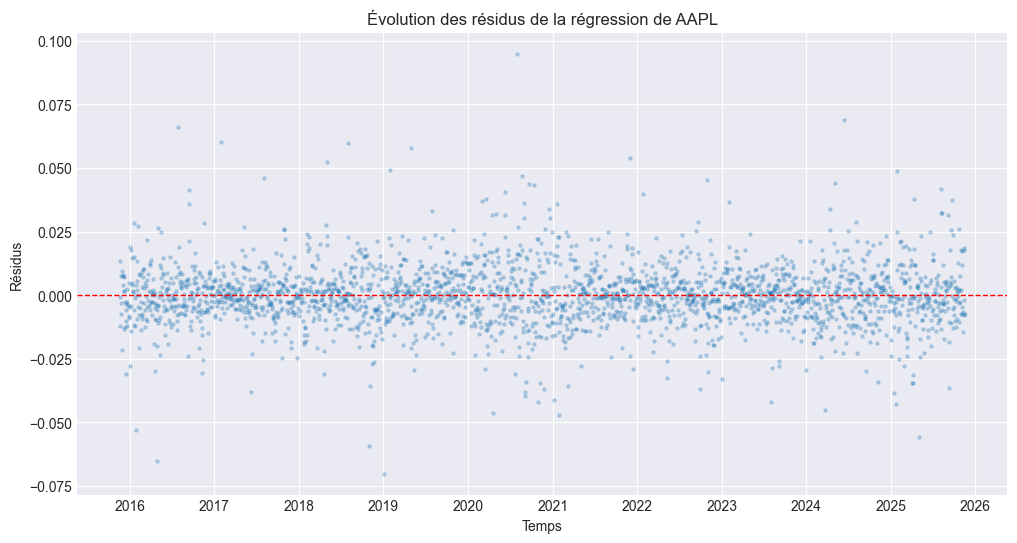

In [86]:
# Évolution des résidus dans le temps
plt.figure(figsize=(12,6))

plt.scatter(residuals.index, residuals, alpha=0.25, s=5)

plt.title(f'Évolution des résidus de la régression de {asset}')
plt.xlabel('Temps')
plt.ylabel('Résidus')
plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.show()

## Graphique 4 : QQ-plot des résidus

<Figure size 800x800 with 0 Axes>

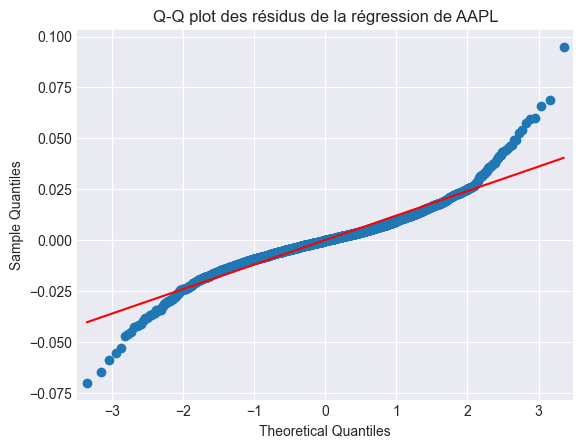

In [87]:
# Q-Q plot des résidus (normalité)
plt.figure(figsize=(8,8))

sm.qqplot(residuals, line ='s')
plt.title(f'Q-Q plot des résidus de la régression de {asset}')

plt.show()

## Le Capital Asset Pricing Model (CAPM)
- Le CAPM relie le rendement attendu d'un actif à son risque systématique (mesuré par $\beta$).
- Il donne un rendement théoriquement "juste" qu'un actif devrait offrir en fonction de son risque.
- Si un actif a un rendement inferieur à celui prédit par le CAPM, il compense mal son risque, il est considéré comme surévalué (et vice versa).

### Formule 
$$
\mathbb{E}[r_i] = r_f + \beta_i (\mathbb{E}[r_m] - r_f)
$$
où :
- $\mathbb{E}[r_i]$ : rendement attendu de l'actif i
- $\mathbb{E}[r_m]$ : rendement attendu du marché
- $\beta_i$ : sensibilité de l'actif i au marché
- $r_f$ : taux sans risque
- $\mathbb{E}[r_m] - r_f$ : prime de risque du marché

## Interprétation
Le CAPM nous donne un rendement attendu basé sur le risque systématique.
- Si un actif a un $\beta$ élevé, il devrait offrir un rendement plus élevé pour compenser le risque additionnel.
- Si un actif a un $\beta$ faible, il offrera un rendement plus faible.

## Exercice / mini-projet de synthèse
- Choisir 3 actifs et un indice de marché (QQQ, SPY, etc.)
- Faire 3 régressions linéaires pour estimer $\alpha$, $\beta$ et le $R^2$ de chaque actif par rapport au marché.
- Analyser les résultats : quels actifs ont les plus hauts $\beta$ ? Quels ont les plus hauts $\alpha$ ?
- Comparer les rendements attendus selon le CAPM avec les rendements historiques observés.
- Discuter des implications pour la gestion de portefeuille et la prise de décision d'investissement.